Total Discrete States: 18
Average Episode Length: 41.952


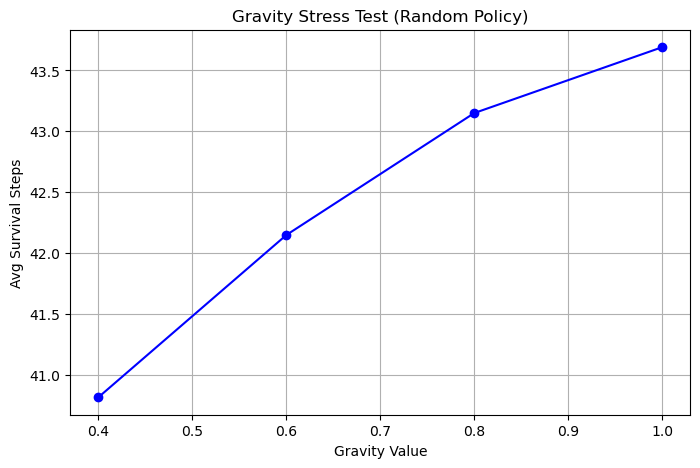

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Task 0: Seeding
np.random.seed(42)
random.seed(42)

# Task 1: Implement the Environment (MDP)
class FlappyEnv:
    def __init__(self, gravity=0.6):
        """Initialize all environment constants."""
        self.width = 400
        self.height = 600
        self.gravity = gravity
        self.flap_velocity = -8
        self.pipe_speed = 5
        self.pipe_width = 50
        self.gap_size = 150
        self.reset()

    def reset(self):
        """Reset bird position, velocity, and pipe location."""
        self.bird_y = self.height // 2
        self.bird_velocity = 0
        self.pipe_x = self.width + 10
        self.pipe_gap_y = random.randint(150, 450)
        self.score = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        """Return state as: (bird_y, bird_velocity, distance_to_pipe, gap_offset)."""
        distance_to_pipe = self.pipe_x - 50  # 50 is bird_x
        gap_offset = self.bird_y - self.pipe_gap_y
        return np.array([self.bird_y, self.bird_velocity, distance_to_pipe, gap_offset])

    def step(self, action):
        """Apply physics, check collisions, and return transition."""
        if self.done:
            return self._get_state(), {'score': self.score, 'done': True, 'passed': False}, True

        # Apply action/gravity
        if action == 1: # flap
            self.bird_velocity = self.flap_velocity
        else:
            self.bird_velocity += self.gravity
        
        self.bird_y += self.bird_velocity
        self.pipe_x -= self.pipe_speed

        # Handle pipe movement and scoring
        passed_pipe = False
        if self.pipe_x < -self.pipe_width:
            self.pipe_x = self.width
            self.pipe_gap_y = random.randint(150, 450)
            self.score += 1
            passed_pipe = True

        # Collision detection
        if self.bird_y < 0 or self.bird_y > self.height:
            self.done = True
        
        if 50 < self.pipe_x + self.pipe_width and 50 + 20 > self.pipe_x:
            if self.bird_y < self.pipe_gap_y - self.gap_size/2 or \
               self.bird_y > self.pipe_gap_y + self.gap_size/2:
                self.done = True

        info = {
            'score': self.score, 
            'done': self.done, 
            'passed': passed_pipe, 
            'gap_offset': self.bird_y - self.pipe_gap_y
        }
        
        return self._get_state(), info, self.done

# Task 2: Markov Property Validation
def is_markov_sufficient(env, state, action=0, trials=10):
    """Verify if the same state and action always lead to the same next state."""
    next_states = []
    for _ in range(trials):
        env.reset()
        env.bird_y, env.bird_velocity, _, _ = state
        env.pipe_x = state[2] + 50
        env.pipe_gap_y = state[0] - state[3]
        next_s, _, _ = env.step(action)
        next_states.append(next_s)
    
    for i in range(1, len(next_states)):
        if not np.allclose(next_states[0], next_states[i]):
            return False
    return True

# Task 3: Discretization
def discretize_state(state):
    """Convert continuous state into discrete bins for Q-Learning."""
    bird_y, velocity, dist_pipe, gap_offset = state
    
    # gap_offset: below, inside, above
    y_bin = 0 if gap_offset < -50 else (2 if gap_offset > 50 else 1)
    
    # velocity: rising, slow, falling
    v_bin = 0 if velocity < -3 else (2 if velocity > 3 else 1)
    
    # distance: near, far
    d_bin = 0 if dist_pipe < 150 else 1
    
    return (y_bin, v_bin, d_bin)

# Task 4: Discrete State Space Size
bins_per_dim = [3, 3, 2] # y_bin * v_bin * d_bin
total_states = np.prod(bins_per_dim)
print(f"Total Discrete States: {total_states}")
assert total_states <= 10000

# Task 5: Reward Functions
def sparse_reward(info):
    if info['done']: return -50
    if info['passed']: return 10
    return 0

def dense_reward(info):
    if info['done']: return -100
    return 0.1 

def shaped_reward(info):
    reward = dense_reward(info)
    reward -= abs(info['gap_offset']) * 0.001 
    return reward

# Task 6: Random Policy Validation
def run_random_policy(env, episodes=500):
    lengths = []
    for _ in range(episodes):
        env.reset()
        done = False
        ep_len = 0
        while not done:
            _, info, done = env.step(random.randint(0, 1))
            ep_len += 1
        lengths.append(ep_len)
    
    avg_len = np.mean(lengths)
    print(f"Average Episode Length: {avg_len}")
    if avg_len < 10: print("Warning: Environment too HARD")
    elif avg_len > 1000: print("Warning: Environment too EASY")

# Task 7: Environment Stress Testing
def stress_test():
    gravities = [0.4, 0.6, 0.8, 1.0]
    results = []
    for g in gravities:
        test_env = FlappyEnv(gravity=g)
        lengths = [0] * 100
        for i in range(100):
            test_env.reset()
            done = False
            while not done:
                _, _, done = test_env.step(random.randint(0, 1))
                lengths[i] += 1
        results.append(np.mean(lengths))

    plt.figure(figsize=(8, 5))
    plt.plot(gravities, results, marker='o', linestyle='-', color='b')
    plt.title("Gravity Stress Test (Random Policy)")
    plt.xlabel("Gravity Value")
    plt.ylabel("Avg Survival Steps")
    plt.grid(True)
    plt.show()

# Execution
env = FlappyEnv()
run_random_policy(env)
stress_test()